# <center> Практическое задание №1 </center>

**Задание:** построить классификатор да/нет из лабораторной работы №4

**Классификатор по варианту:** KNN

In [29]:
import warnings
import librosa
import numpy as np
import scipy
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve

%matplotlib inline

warnings.filterwarnings('ignore')

Загрузим весь датасет

In [2]:
# Скачаем его
#  надёжнее использовать скачивание вручную, либо попробовать строчку ниже
![ ! -f  waves_yesno.tar.gz ] && wget https://www.openslr.org/resources/1/waves_yesno.tar.gz
# И распакуем
!tar -xvzf waves_yesno.tar.gz

--2023-03-09 17:19:05--  https://www.openslr.org/resources/1/waves_yesno.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://us.openslr.org/resources/1/waves_yesno.tar.gz [following]
--2023-03-09 17:19:05--  http://us.openslr.org/resources/1/waves_yesno.tar.gz
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4703754 (4.5M) [application/x-gzip]
Saving to: ‘waves_yesno.tar.gz’

waves_yesno.tar.gz  100%[===================>]   4.49M  5.49MB/s    in 0.8s    

2023-03-09 17:19:07 (5.49 MB/s) - ‘waves_yesno.tar.gz’ saved [4703754/4703754]

waves_yesno/
waves_yesno/1_0_0_0_0_0_1_1.wav
waves_yesno/1_1_0_0_1_0_1_0.wav
waves_yesno/1_0_1_1_1_1_0_1.wav
waves_yesno/1_1_1_1_0_1_0_0.wav
waves_yesno/

In [3]:
def load_yn_dataset(directory):
    X, labels = [], []
    bad_files = set(["0_1_0_1_0_0_0_0"])
    for f in glob(directory + "/*.wav"):
        name = os.path.basename(f)[:-4]
        if name in bad_files:
            continue
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)

    return X, labels


X, Y = load_yn_dataset("waves_yesno/")

Послушаем одну вавку:

In [4]:
wav, sr = librosa.load("waves_yesno/0_1_0_1_0_0_0_0.wav")
ipd.Audio(wav, rate=sr)

Отделим 20% для теста

In [47]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=0)

# VAD

---


Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре.
Реализуйте простой VAD. Настройте VAD, чтобы хорошо определялись границы слов.

Подсказка:
Можно отличать паузу от речи по энергии mfcc спектра( или части спектра). Чтобы предотвратить скачки на краях слов, воспользуйтесь сверткой со сглаживающим окном, например, Ханна.

Идея повторяет лабораторную №4: самый простой вариант VAD - сравниваем энергию mfcc спектра с некоторым пороговым значением (значение подбираем вручную так, чтобы было как можно меньше ошибочно определенных пауз), перед этим выполняем свертку для сглаживания скачков

In [7]:
def mel(spec):
    # spec - stft spectrogram
    mel_scale = 2595*np.log10(1 + spec/700)
    #mel_scale = 1125*np.log(1 + spec/700)
    return mel_scale

def mel_filters_librosa(sr, n_fft, n_mels):
    # функция построения треугольных мел-фильтров в герц-шкале
    # sr - sample rate
    # n_fft - length of the FFT window
    # n_mels - number of filters
    # return mel filters matrix. [n_mel, n_fft]

    fmax = float(sr) / 2
    fmin = 0
    m = np.linspace(mel(fmin), mel(fmax), num=n_mels+2)
    h = 700.0 * (10.0 ** (m / 2595.0) - 1.0)
    f_bank = np.zeros((n_mels, int(n_fft/2) + 1))
    fft_freqs = np.linspace(0, sr / 2, 1 + n_fft // 2)
    f_diff = np.diff(h)
    ramps = np.subtract.outer(h, fft_freqs)

    for i in range(n_mels):
        lower = -ramps[i] / f_diff[i]
        upper = ramps[i + 2] / f_diff[i + 1]
        f_bank[i] = np.maximum(0, np.minimum(lower, upper))

    enorm = 2.0 / (h[2:n_mels + 2] - h[:n_mels])
    f_bank *= enorm[:, np.newaxis]

    return f_bank

def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_ms=10, n_fbanks=40):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_fbanks - number of filters
    # return fbank matrix [n_fbanks, time]
    n_fft = window_ms * sr//1000
    hop_length = step_ms * sr//1000
    spec = np.abs(librosa.stft(wav, n_fft=n_fft,
                  hop_length=hop_length, window='hann', center=True))**2
    mel_filters = mel_filters_librosa(sr, n_fft, n_fbanks)

    return np.dot(mel_filters, spec)

def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_ms=10, n_mfcc=13):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_mfcc - number of filters
    # return mfcc matrix [n_mfcc, time]
    fbanks = get_fbanks(wav, sr, window_ms, step_ms, 128)
    log_spec = librosa.power_to_db(fbanks)
    mel_coeff = scipy.fftpack.dct(
        log_spec, axis=0, type=2, norm='ortho')[:n_mfcc]
    return mel_coeff

In [20]:
def VAD(wav, sr, threshold):
    # wav - input signal
    # sr - sample rate
    # threshold - threshold value for voice recognition
    mfcc = get_mfcc(wav, sr, window_ms=25, step_ms=10)[1]
    mfcc = np.repeat(mfcc, 10 * sr//1000)
    mfcc = np.resize(mfcc, len(wav))

    wind = scipy.signal.get_window("hann", 3000)
    mfcc_wind = np.convolve(mfcc, wind, 'same')/3000

    vad = np.zeros(len(mfcc_wind))
    vad[mfcc_wind > threshold] = 1

    return vad

In [48]:
train_VA = [VAD(x, sr, 96) for x in X_train]
test_VA = [VAD(x, sr, 96) for x in X_test]

In [49]:
def test_VAD(VOICE, VA, Y, min_acc=0.95):
    def check_ali(ali, num_words):
        diff = ali[1:] - ali[:-1]
        if diff.sum() != 0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1
        if not (diff > 0).sum() == (diff > 0).sum() == num_words:
            return -2
        return 0

    bad_i = []
    err = 0
    for i, (ali, y) in enumerate(zip(VA, Y)):
        assert len(VOICE[i]) == len(ali), "shapes doesn't match"
        if check_ali(ali, len(y)) != 0:
            bad_i.append(i)
            err += 1
    acc = (len(Y) - err)/len(Y)
    print(f"Accuracy {acc}")
    if len(bad_i) > 0:
        print(f"ids with error {bad_i}")
    assert acc >= min_acc, f"Accuracy must be >= {min_acc}"
    print("Test passed")


test_VAD(X_train, train_VA, Y_train)
test_VAD(X_test, test_VA, Y_test)
print("VAD ok!")

Accuracy 1.0
Test passed
Accuracy 1.0
Test passed
VAD ok!


Визуализируем результат работы VAD

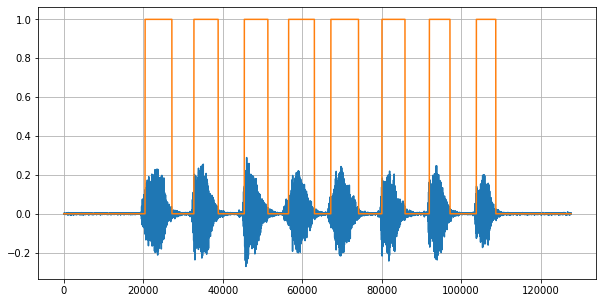

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(X_train[2])
plt.plot(train_VA[2])
plt.grid()

# Построение классификатора
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки выделеных VAD'ом слов. Или любым другим удобным для вас способом. Добейтесь точности больше 0.95

Подготовим данные для обучения. В качестве признаков возьмем усредненные по фильтрам значения mfcc каждого слова, в качестве меток - исходные метки слов. Будем выделять границы слов с помощью VAD, затем рассчитывать mfcc для каждого отдельного слова и усреднять полученные значения по числу фильтров. Таким образом все признаки будут иметь размерность равную числу фильтров, в нашем случае 13.

In [23]:
# prepare data

def get_bounds(x_vad):
    # return indexes of words bounds
    bounds = [i for i in range(1, len(x_vad)) if x_vad[i] != x_vad[i-1]]
    return np.array(bounds)


def pre_process(x, y, vad, sr=22050):
    # return mean mfcc of words and their labels
    x_new, y_new = [], []
    words_bounds = get_bounds(vad)

    for j in range(0, len(words_bounds), 2):
        word = x[words_bounds[j]:words_bounds[j+1]]
        word_mfcc = get_mfcc(word, sr)
        x_new.append(np.mean(word_mfcc, axis=1))
        y_new.append(y[j//2])

    return x_new, y_new

In [51]:
x_train, y_train = [], []
for (x, y, vad) in zip(X_train, Y_train, train_VA):
    x_new, y_new = pre_process(x, y, vad)
    x_train.extend(x_new)
    y_train.extend(y_new)

In [52]:
x_test, y_test = [], []
for (x, y, vad) in zip(X_test, Y_test, test_VA):
    x_new, y_new = pre_process(x, y, vad)
    x_test.extend(x_new)
    y_test.extend(y_new)

Визуализируем тренировочные данные. Для того, чтобы данные можно было отобразить в двумерном пространстве, уменьшим число компонент исходных признаков до двух с помощью PCA.

In [53]:
pca = PCA(n_components=2, random_state=0)
x_train_pca = pca.fit_transform(x_train)

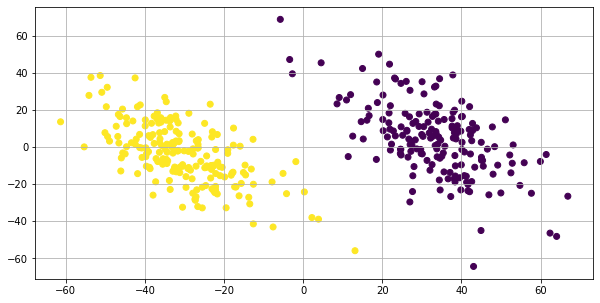

In [54]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train)
ax.grid()

По полученному двумерному представлению можно сказать, что классы кажутся хорошо отделимы друг от друга.

Обучим классификатор, в качетсве классификатора будем использовать KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

In [56]:
y_pred = knn.predict(x_test)

In [57]:
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


Визуализируем результаты классификации. 

In [75]:
pca = PCA(n_components=2, random_state=0)
x_test_pca = pca.fit_transform(x_test)

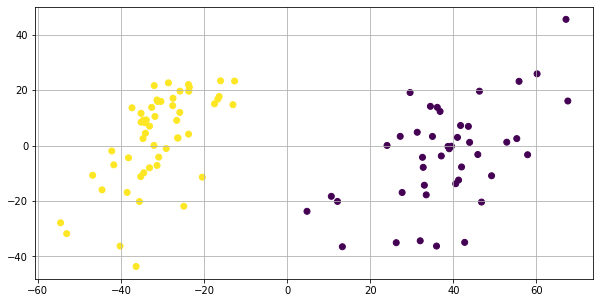

In [76]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_pred)
ax.grid()

Визуализируем кривые обучения классификатора 

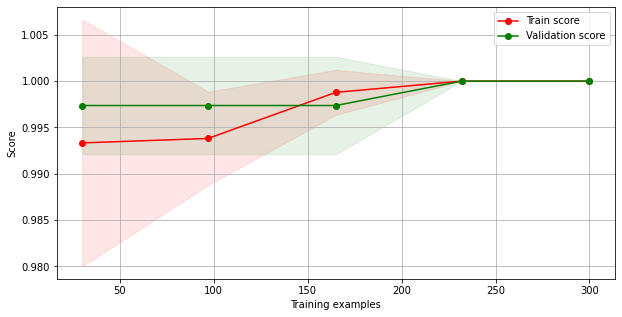

In [70]:
train_sizes, train_scores, test_scores = learning_curve(
    knn, x_train, y_train, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

_, axes = plt.subplots(1, 1, figsize=(10, 5))

axes.set_xlabel("Training examples")
axes.set_ylabel("Score")
axes.grid()
axes.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)

axes.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Train score")
axes.plot(train_sizes, test_scores_mean, "o-",
          color="g", label="Validation score")
axes.legend(loc="best")